# HOSPITAL EFFICIENCY PROJECT

# Discrete-event simulation for elective orthopaedic theatre and ward planning

In [1]:
import simpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import arrow
import random
import math
import warnings

## Set start date and define it to be equal to the simulation time
This allows monitoring of weekdays 

Defined in days: Monday = 0

In [2]:
start = arrow.get('2022-06-27')  
# start on a monday
env = simpy.Environment()

In [3]:
# #checking - note start a/a not in real time.  Monday=0
# current_date = start.shift(days=env.now)
# print('Current weekday:', current_date.weekday())

# tomorrow_date = current_date.shift(days=+1)
# print('Tomorrow weekday:', tomorrow_date.weekday())

# start.shift(days=env.now).weekday()

## Parameters
* Primary: primary hip, primary knee, primary uni-compartmental knee
* Revision: revision hip, revision knee

delay_los count    529.000000  
*mean      16.521739  
*std       15.153132  
*min        2.000000   
*25%        8.000000  
*50%       13.000000  
*75%       19.000000  
*max      156.000000  

primary_knee count    2150.000000  
*mean        4.651163  
*std         2.828129  
*min         0.000000  
*25%         3.000000  
*50%         4.000000  
*75%         6.000000  
*max        42.000000  

uni_knee count    668.000000  
*mean       2.914671  
*std        2.136334  
*min        0.000000  
*25%        2.000000  
*50%        3.000000  
*75%        4.000000  
*max       16.000000  

revise_knee count    340.000000  
*mean       7.194118  
*std        7.598554  
*min        0.000000  
*25%        3.000000  
*50%        5.000000  
*75%        9.000000  
*max       63.000000  

primary_hip count    2820.000000  
*mean        4.433333  
*std         2.949526  
*min         0.000000  
*25%         3.000000  
*50%         4.000000  
*75%         5.000000  
*max        44.000000  

revise_hip count    406.000000  
*mean       6.908867  
*std        6.965812  
*min        0.000000  
*25%        3.000000  
*50%        5.000000  
*75%        8.000000  
*max       86.000000  

In [4]:
# ward parameters
DEFAULT_PRIMARY_HIP_MEAN_LOS = 4.433333 
DEFAULT_PRIMARY_KNEE_MEAN_LOS =  4.651163 
DEFAULT_REVISION_HIP_MEAN_LOS = 6.908867 
DEFAULT_REVISION_KNEE_MEAN_LOS = 7.194118 
DEFAULT_UNICOMPART_KNEE_MEAN_LOS = 2.914671 

DEFAULT_PRIMARY_HIP_SD_LOS = 2.949526
DEFAULT_PRIMARY_KNEE_SD_LOS = 2.828129
DEFAULT_REVISION_HIP_SD_LOS = 6.965812
DEFAULT_REVISION_KNEE_SD_LOS = 7.598554
DEFAULT_UNICOMPART_KNEE_SD_LOS = 2.136334

DEFAULT_DELAY_POST_LOS_MEAN = 16.521739
DEFAULT_DELAY_POST_LOS_SD = 15.153132

DEFAULT_PROB_WARD_DELAY = 0.076  

# ward resources
DEFAULT_NUMBER_BEDS = 40

DEFAULT_PRIMARY_DICT = {1: 'p_hip', 2: 'p_knee', 3: 'uni_knee'}
DEFAULT_REVISION_DICT = {1: 'r_hip', 2: 'r_knee'}
DEFAULT_PRIMARY_PROB = [0.51, 0.38, 0.11]
DEFAULT_REVISION_PROB = [0.55, 0.45]

SET_WEEKDAY = ['Monday', 'Tuesday', 'Wednesday', 'Thursday',
               'Friday', 'Saturday', 'Sunday']
SET_SESSIONS_PER_WEEKDAY = {'Monday': 3, 'Tuesday': 3, 'Wednesday': 3, 'Thursday': 3,
                            'Friday': 3, 'Saturday': 0, 'Sunday': 0}
SET_SESSIONS_PER_WEEKDAY_LIST = list(SET_SESSIONS_PER_WEEKDAY.values())
SET_ALLOCATION = {'Monday': ['2P_or_1R', '2P_or_1R', '1P'],
                  'Tuesday': ['2P_or_1R', '2P_or_1R', '1P'],
                  'Wednesday': ['2P_or_1R', '2P_or_1R', '1P'],
                  'Thursday': ['2P_or_1R', '2P_or_1R', '1P'],
                  'Friday': ['2P_or_1R', '2P_or_1R', '1P'],
                  'Saturday': [],
                  'Sunday': []}
SET_THEATRES_PER_WEEKDAY = {'Monday': 4, 'Tuesday': 4, 'Wednesday': 4, 'Thursday': 4,
                            'Friday': 4, 'Saturday': 0, 'Sunday': 0}

# simulation parameters
DEFAULT_NUMBER_OF_RUNS = 5
DEFAULT_RESULTS_COLLECTION_PERIOD = 42
results_collection_period = 70
DEFAULT_WARM_UP_PERIOD = 7
default_rng_set = None

# for returning results per day
first_obs = 1
interval = 1

TRACE = False

# extreme schedule generated for testing
new_schedule = pd.read_csv('new_schedule.csv')
print(new_schedule.head(7))

   Unnamed: 0  index        Day  Primary_slots  Revision_slots
0           0      0     Monday             24               8
1           1      1    Tuesday             28               6
2           2      2  Wednesday             24               8
3           3      3   Thursday             22               9
4           4      4     Friday             22               9
5           5      5   Saturday             34               7
6           6      6     Sunday             32               8


## TOM NOTES

one long run 10 yrs p159 robinson, Banks et al  

sensitivity analysis - los params and distrib (lnorm, gamma, edf) +/- trunc  

outliers, double peak etc  

vary run lengths eg 1mth vs 1 year  

outputs by day and by patient  

2k design, interaction - robinson, tom paper

MORE plots

In [5]:
# later for translation: ignore this - testing
primary_dict = {1: 'p_hip', 2: 'p_knee', 3: 'uni_knee'}
revision_dict = {1: 'r_hip', 2: 'r_knee'}
primary_prop = np.random.choice(np.arange(1, 4), p=[0.4, 0.4, 0.2])
revision_prop = np.random.choice(np.arange(1, 3), p=[0.6, 0.4])

def vec_tran(prop, dict):
    return np.vectorize(dict.__getitem__)(prop)

# trial sample and vectorize by dict key
primary_sample = vec_tran(primary_prop, primary_dict)

## Trace utility for debugging

In [6]:
def trace(msg):
    """
    If TRUE will return all patient level message output"""
    if TRACE:
        print(msg)

## Distribution classes for generating LoS and branching
* Used to control random number sampling
* Each distribution has its own stream
* Lognormal for lengths-of-stay
* Bernoulli for determining lost theatres slots and delayed discharges

In [7]:
class Lognormal:
    """for creating LoS distributions for each patient type"""
    def __init__(self, mean, stdv, random_seed=None):
        self.rng = np.random.default_rng(seed=random_seed)
        mu, sigma = self.calc_params(mean, stdv)
        self.mu = mu
        self.sigma = sigma

    def calc_params(self, mean, stdv):
        phi = (stdv ** 2 + mean ** 2) ** 0.5
        mu = np.log(mean ** 2 / phi)
        sigma = (np.log(phi ** 2 / mean ** 2)) ** 0.5
        return mu, sigma

    def sample(self):
        """
        method to generate a sample from the lognormal distribution
        """
        return self.rng.lognormal(self.mu, self.sigma)

class Bernoulli:
    """for pathway branching: slots lost on day, 
    patients whose LoS is delayed due to downstream processes
    """
    def __init__(self, p, random_seed = None):
        """p = prob of drawing a 1"""
        self.rng = np.random.default_rng(seed=random_seed)
        self.p = p

    def sample(self, size = None):
        """
        method to generate a sample from the Bernoulli distribution
        """
        return self.rng.binomial(n = 1, p = self.p, size = size) 

class Gamma:
    """ sensitivity analysis on LoS distributions for each patient type"""
    def __init__(self, mean, stdv, random_seed = None):
        self.rng = np.random.default_rng(seed = random_seed)
        scale, shape = self.calc_params(mean, stdv)
        self.scale = scale
        self.shape = shape

    def calc_params(self, mean, stdv):
        scale = (stdv **2) / mean 
        shape = (stdv **2) / (scale **2)
        return scale, shape

    def sample(self, size = None):
        """
        method to generate a sample from the gamma distribution
        """
        return self.rng.gamma(self.shape, self.scale, size = size)   

## Theatre schedule
 Default settings:
* 4 theatres (2-6)
* 5 day/week (5-7)
* Each theatre has three sessions per day:
        * Morning: 1 revision OR 2 primary
        * Afternoon: 1 revision OR 2 primary
        * Evening: 1 primary
        

In [8]:
  class Schedule:
        
#     """
#     Creates theatre schedule according to rules
#     """
    def __init__(self, weekday=SET_WEEKDAY,
                allocation=SET_ALLOCATION,
                sessions_per_weekday=SET_SESSIONS_PER_WEEKDAY,
                sessions_per_weekday_list=SET_SESSIONS_PER_WEEKDAY_LIST,
                theatres_per_weekday=SET_THEATRES_PER_WEEKDAY):
        """
        parameters used to create schedule defined in 'scenarios class'
        """
        self.weekday=weekday
        self.allocation=allocation
        self.sessions_per_weekday=sessions_per_weekday
        self.sessions_per_weekday_list=sessions_per_weekday_list
        self.theatres_per_weekday=theatres_per_weekday
        
    def create_schedule(self,weekday, sessions_per_weekday_list, allocation, theatres_per_weekday):
        """
        Arguments needed:
            *weekday: a list of weekdays
            *sessions_per_weekday: a list of integers representing the number of sessions per weekday
            *allocation: a dictionary where the keys are the weekdays and the values are lists of 
                        allocations for each session 
            *theatres_per_weekday: a dictionary where the keys are the weekdays and the values are 
                        integers representing the number of theatres per weekday 
        Returns a dictionary where the keys are the weekdays and the values are lists 
                        of lists of allocations for each theatre for each session.
        """
        schedule = {}
        for day, num_sessions in zip(weekday, sessions_per_weekday_list):
            schedule[day] = []
            for theatre in range(theatres_per_weekday[day]):
                schedule[day].append([])
                for session in range(num_sessions):
                    if allocation[day][session] == '1P':
                        schedule[day][theatre].append({'primary': 1})
                    elif allocation[day][session] == '1R':
                        schedule[day][theatre].append({'revision': 1})
                    elif allocation[day][session] == '2P':
                        schedule[day][theatre].append({'primary': 2})
                    elif allocation[day][session] == '2P_or_1R':
                        if random.random() > 0.5:
                            schedule[day][theatre].append({'primary': 2})
                        else:
                            schedule[day][theatre].append({'revision': 1})
        return schedule
        
    def daily_counts(self,day_data):
        """
        day_data: called in week_schedule() function, day_data is a sample weekly dictionary from create_schedule()
        Convert dict to a pandas DataFrame with 'primary' and 'revision' as columns 
        and days of the week as the index, populated with the total count of 'primary' and 'revision' in each day.
        Returns a one week schedule
        """
        #day_data = create_schedule(weekday, sessions_per_weekday, allocation, theatres_per_weekday)
        primary_slots = 0
        revision_slots = 0
        for value in day_data:
            if value:
                for sub_value in value:
                    if 'primary' in sub_value:
                        primary_slots += sub_value['primary']
                    if 'revision' in sub_value:
                        revision_slots += sub_value['revision']
        return [primary_slots, revision_slots]

    def week_schedule(self):
        """
        samples a weekly dictionary of theatres, sessions, and surgeries from create_schedule()
        counts daily number or primary and revision surgeries needed using daily_counts()
        and converts to a dataframe
        """
        week_sched = pd.DataFrame(columns=['Primary_slots', 'Revision_slots'])
        day_data = self.create_schedule(self.weekday, self.sessions_per_weekday_list,
                                   self.allocation, self.theatres_per_weekday)
        for key, value in day_data.items():
            week_sched.loc[key] = self.daily_counts(value)
        week_sched = week_sched.reset_index()
        week_sched.rename(columns = {'index':'Day'}, inplace = True)
        return week_sched

    def theatre_capacity(self):
        length_sched = int(round(2*(DEFAULT_WARM_UP_PERIOD+DEFAULT_RESULTS_COLLECTION_PERIOD)/7, 0))

        DEFAULT_SCHEDULE_AVAIL = pd.DataFrame()
        for week in range(length_sched):
            single_random_week = self.week_schedule()
            DEFAULT_SCHEDULE_AVAIL = pd.concat([DEFAULT_SCHEDULE_AVAIL, single_random_week],axis=0)
        return DEFAULT_SCHEDULE_AVAIL.reset_index()

# class Save:
#     schedule = Schedule()
#     def __init__(self, schedule):
#         self.schedule = schedule
    
#     schedule_avail3 = schedule.theatre_capacity()
#     print(schedule_avail3.head(7))
#     schedule_avail3.to_csv('data/new_schedule_checking.csv')

## Scenarios class 

In [9]:
class Scenario:
    """
    Holds LoS dists for each patient type
    Holds delay dists
    Holds prob of delay, prob of same day dist
    Holds resources: beds
    Passed to hospital model and process classes
    """
    def __init__(self, schedule, schedule_avail=None, 
                 random_number_set=default_rng_set,
                 primary_hip_mean_los=DEFAULT_PRIMARY_HIP_MEAN_LOS,
                 primary_knee_mean_los=DEFAULT_PRIMARY_KNEE_MEAN_LOS,
                 revision_hip_mean_los=DEFAULT_REVISION_HIP_MEAN_LOS,
                 revision_knee_mean_los=DEFAULT_REVISION_KNEE_MEAN_LOS,
                 unicompart_knee_mean_los=DEFAULT_UNICOMPART_KNEE_MEAN_LOS,
                 delay_post_los_mean=DEFAULT_DELAY_POST_LOS_MEAN,
                 prob_ward_delay=DEFAULT_PROB_WARD_DELAY,
                 n_beds=DEFAULT_NUMBER_BEDS,
                 primary_hip_sd_los=DEFAULT_PRIMARY_HIP_SD_LOS,
                 primary_knee_sd_los=DEFAULT_PRIMARY_KNEE_SD_LOS,
                 revision_hip_sd_los=DEFAULT_REVISION_HIP_SD_LOS,
                 revision_knee_sd_los=DEFAULT_REVISION_KNEE_SD_LOS,
                 unicompart_knee_sd_los=DEFAULT_UNICOMPART_KNEE_SD_LOS,
                 delay_post_los_sd=DEFAULT_DELAY_POST_LOS_SD,
                 primary_dict=DEFAULT_PRIMARY_DICT,
                 revision_dict=DEFAULT_REVISION_DICT,
                 primary_prob=DEFAULT_PRIMARY_PROB,
                 revision_prob=DEFAULT_REVISION_PROB):
    
        """
        controls initial seeds of each RNS used in model
        """
        self.schedule = schedule
        if schedule_avail is None:
            self.schedule_avail = schedule.theatre_capacity()
            
        else:
            self.schedule_avail = schedule_avail
        #self.schedule_avail = schedule_avail   
        self.random_number_set = random_number_set
        self.primary_hip_mean_los = primary_hip_mean_los
        self.primary_knee_mean_los = primary_knee_mean_los
        self.revision_hip_mean_los = revision_hip_mean_los 
        self.revision_knee_mean_los = revision_knee_mean_los
        self.unicompart_knee_mean_los = unicompart_knee_mean_los
        self.n_beds = n_beds
        self.prob_ward_delay = prob_ward_delay
        self.primary_hip_sd_los = primary_hip_sd_los
        self.primary_knee_sd_los = primary_knee_sd_los
        self.revision_hip_sd_los = revision_hip_sd_los
        self.revision_knee_sd_los = revision_knee_sd_los
        self.unicompart_knee_sd_los = unicompart_knee_sd_los
        self.delay_post_los_mean = delay_post_los_mean
        self.delay_post_los_sd = delay_post_los_sd
        self.primary_dict = primary_dict
        self.revision_dict = revision_dict
        self.primary_prob = primary_prob
        self.revision_prob = revision_prob
        self.init_sampling()

    def set_random_no_set(self, random_number_set):
        """
        controls random sampling for each distribution used in simulations"""
        self.random_number_set = random_number_set
        self.init_sampling()
        
    def init_sampling(self):
        """
        distribs used in model and initialise seed"""
        rng_streams = np.random.default_rng(self.random_number_set)
        self.seeds = rng_streams.integers(0,99999999999, size = 20)
        
        #######  Distributions ########
        # LoS distribution for each surgery patient type
        self.primary_hip_dist = Lognormal(self.primary_hip_mean_los, self.primary_hip_sd_los,
                                          random_seed=self.seeds[0])
        self.primary_knee_dist = Lognormal(self.primary_knee_mean_los, self.primary_knee_sd_los,
                                          random_seed=self.seeds[1])
        self.revision_hip_dist = Lognormal(self.revision_hip_mean_los, self.revision_hip_sd_los,
                                          random_seed=self.seeds[2])
        self.revision_knee_dist = Lognormal(self.revision_knee_mean_los, self.revision_knee_sd_los,
                                          random_seed=self.seeds[3])
        self.unicompart_knee_dist = Lognormal(self.unicompart_knee_mean_los, self.unicompart_knee_sd_los,
                                          random_seed=self.seeds[4])
        
        # distribution for delayed LoS
        self.los_delay_dist = Lognormal(self.delay_post_los_mean, self.delay_post_los_sd,
                                       random_seed=self.seeds[5])
        
        #probability of having LoS delayed on ward
        self.los_delay = Bernoulli(self.prob_ward_delay, random_seed=self.seeds[7])
        
    def number_slots(self, schedule_avail):
        """
        convert to np arrays for each surgery type for patient generators
        """
        self.schedule_avail_primary = self.schedule_avail['Primary_slots'].to_numpy()
        self.schedule_avail_revision = self.schedule_avail['Revision_slots'].to_numpy()
        return(self.schedule_avail_primary, self.schedule_avail_revision)

    def primary_types(self,prob):
        """
        randomly select primary surgical type from custom distribution: primary_prop
        prob = primary_prop
        used for generating primary patients of each surgical type
        """
        self.primary_surgery = np.random.choice(np.arange(1,4), p=prob)
        return(self.primary_surgery)
    
    def revision_types(self,prob):
        """
        randomly select revision surgical type from custom distribution: revision_prop
        prob = revision_prop
        used for generating revision patients of each surgical type
        """
        self.revision_surgery = np.random.choice(np.arange(1,3), p=prob)
        return(self.revision_surgery)
     
    def label_types(self, prop, dict): 
        """
        return label for each surgery type
        """
        return np.vectorize(dict.__getitem__)(prop)
    

## Set up process to get started: patient pathways
Patient journeys for primary and revision patients




In [10]:
class PrimaryPatient:
    """
    The process a patient needing primary hip or knee surgery will undergo
    from scheduled admission for surgery to discharge
    
    day = simulation day
    id = patient id
    args: Scenario parameter class
    """
    def __init__(self, day, id, env, args):
        
        self.day = day
        self.id = id
        self.env = env
        self.args = args
        
        self.arrival = -np.inf
        self.queue_beds = -np.inf
        self.primary_los = 0
        self.total_time = -np.inf
        self.depart = -np.inf
        
        self.lost_slots_bool = False
        self.delayed_los_bool = False
        self.weekday = 0
        
    def service(self):
        """
        Arrive according to theatres schedule
        Some patients will leave on day of surgery and the slot is lost
        Some patients will have their surgery cancelled due to lack of beds
        Otherwise, patient is admitted and stays in a bed
        Some patients will have a post-bed request delay to their LoS
        Patient is discharged
        """
        
        self.arrival = self.env.now
        self.patient_class = 'primary'
        self.weekday = start.shift(days=self.env.now).weekday()
        
        # set los for primary surgery types
        self.types = int(self.args.primary_types(self.args.primary_prob))
        if self.types == 1:
            self.primary_los = self.args.primary_hip_dist.sample()
            self.primary_label = 'p_hip'
        elif self.types == 2:
            self.primary_los = self.args.primary_knee_dist.sample()
            self.primary_label = 'p_knee'
        else: 
            self.primary_los = self.args.unicompart_knee_dist.sample()
            self.primary_label = 'uni_knee'

        #vectorize according to dict key to get surgical type
        #self.primary_label = self.args.label_types(primary_prop, primary_dict)   
            
        #sample if need for delayed discharge
        self.need_for_los_delay = self.args.los_delay.sample()
        
        #Patients who have a delayed discharge follow this pathway
        if self.need_for_los_delay:
            
            #request a bed on ward - if none available within 0.5-1 day, patient has surgery cancelled
            with self.args.beds.request() as req:
                
                admission = random.uniform(0.5,1)
                admit = yield req | self.env.timeout(admission)

                if req in admit:
                    """record queue time for primary patients -- if > admission, 
                    this patient will leave the system and the slot is lost"""
                    
                    self.queue_beds = self.env.now - self.arrival
                    trace(f'primary patient {self.id} {self.primary_label}' 
                          f'has been allocated a bed at {self.env.now:.3f}' 
                          f'and queued for {self.queue_beds:.3f}')
                    
                    self.primary_los = args.los_delay_dist.sample()
                    yield self.env.timeout(self.primary_los)
                    self.lost_slots_bool = False
                    self.delayed_los_bool = True
                    self.depart = self.env.now
                    trace(f'los of primary patient {self.id} completed at {self.env.now:.3f}')
                    self.total_time = self.env.now - self.arrival
                    trace(f'primary patient {self.id} {self.primary_label}'
                          f'total los = {self.total_time:.3f} with delayed discharge')
                else:
                    #patient had to leave as no beds were available on ward
                    self.no_bed_cancellation = self.env.now - self.arrival
                    trace(f'primary patient {self.id} {self.primary_label}'
                          f'had surgery cancelled after {self.no_bed_cancellation:.3f}')
                    self.queue_beds = self.env.now - self.arrival
                    self.total_time = self.env.now - self.arrival
                    self.primary_los = 0
                    self.lost_slots_bool = True
                    self.delayed_los_bool = False
                    self.depart = self.env.now
                    trace(f'primary patient {self.id} {self.primary_label}' 
                          f'recorded {self.lost_slots_bool}')
        #no delayed los
        else:
            #request a bed on ward - if none available within 0.5-1 day, patient has surgery cancelled
            with self.args.beds.request() as req:
                admission = random.uniform(0.5,1)
                admit = yield req | self.env.timeout(admission)
                self.no_bed_cancellation = self.env.now - self.arrival

                if req in admit:
                    #record queue time for primary patients -- if >1, this patient will leave the system and the slot is lost
                    self.queue_beds = self.env.now - self.arrival
                    trace(f'primary patient {self.id} {self.primary_label}'
                          f'has been allocated a bed at {self.env.now:.3f}'
                          f'and queued for {self.queue_beds:.3f}')

                    self.primary_los = self.primary_los
                    yield self.env.timeout(self.primary_los)
                    self.lost_slots_bool = False
                    self.delayed_los_bool = False
                    self.depart = self.env.now
                    trace(f'los of primary patient {self.id} {self.primary_label}'
                          f'completed at {self.env.now:.3f}')
                    self.total_time = self.env.now - self.arrival
                    trace(f'primary patient {self.id} {self.primary_label}'
                          f'total los = {self.total_time:.3f}')
                    
                else:
                    #patient had to leave as no beds were available on ward
                    trace(f'primary patient {self.id} {self.primary_label}'
                          f'had surgery cancelled after {self.no_bed_cancellation:.3f}')
                    self.queue_beds = self.env.now - self.arrival
                    self.total_time = self.env.now - self.arrival
                    self.primary_los = 0
                    self.lost_slots_bool = True
                    self.delayed_los_bool = False
                    self.depart = self.env.now
                    trace(f'primary patient {self.id} {self.primary_label}' 
                          f'recorded {self.lost_slots_bool}')
    
class RevisionPatient:
    """
    The process a patient needing revision hip or knee surgery will undergo
    from scheduled admission for surgery to discharge
    
    day = simulation day
    id = patient id
    args: Scenario parameter class
    """
    def __init__(self, day, id, env, args):
        
        self.day = day
        self.id = id
        self.env = env
        self.args = args
        
        self.arrival = -np.inf
        self.queue_beds = -np.inf
        self.revision_los = 0
        self.total_time = -np.inf
        self.depart = -np.inf
        
        self.lost_slots_bool = False
        self.delayed_los_bool = False
        self.weekday = 0
        
        
    def service(self):
        """
        Arrive according to theatres schedule
        Some patients will leave on day of surgery and the slot is lost
        Some patients will have their surgery cancelled due to lack of beds
        Otherwise, patient is admitted and stays in a bed
        Some patients will have a post-bed request delay to their LoS
        Patient is discharged
        """
     
        self.arrival = self.env.now
        self.patient_class = 'revision'
        self.weekday = start.shift(days=self.env.now).weekday()
        
        # set los for revision surgery types
        self.types = int(self.args.revision_types(self.args.revision_prob))
        if self.types == 1:
            self.revision_los = self.args.revision_hip_dist.sample()
            self.revision_label = 'r_hip'
        else: 
            self.revision_los = self.args.revision_knee_dist.sample()
            self.revision_label = 'r_knee'
            
        #vectorize according to dict key to get surgical type
        #self.revision_label = self.args.label_types(revision_prop, revision_dict) 
        
        #sample if need for delayed discharge
        self.need_for_los_delay = self.args.los_delay.sample()
        
        if self.need_for_los_delay:    
        
        #request bed on ward - if none available within 0.5-1  day, patient has surgery cancelled
            with self.args.beds.request() as req:
                admission = random.uniform(0.5, 1)
                admit = yield req | self.env.timeout(admission)

                if req in admit:
                    #record queue time for primary patients -- if >admission, this patient will leave the system and the slot is lost
                    self.queue_beds = self.env.now - self.arrival
                    trace(f'revision patient {self.id} {self.revision_label}'
                          f'has been allocated a bed at {self.env.now:.3f}'
                          f'and queued for {self.queue_beds:.3f}')
                
                    self.revision_los = args.los_delay_dist.sample()
                    yield self.env.timeout(self.revision_los)
                    self.lost_slots_bool = False
                    self.delayed_los_bool = True
                    self.depart = self.env.now
                    trace(f'los of revision patient {self.id} {self.revision_label}'
                          f'completed at {self.env.now:.3f}')
                    self.total_time = self.env.now - self.arrival
                    trace(f'revision patient {self.id} {self.revision_label}'
                          f'total los = {self.total_time:.3f} with delayed discharge')

                else:
                    #patient had to leave as no beds were available on ward
                    self.no_bed_cancellation = self.env.now - self.arrival
                    trace(f'revision patient {self.id}'
                          f'had surgery cancelled after {self.no_bed_cancellation:.3f}')
                    self.queue_beds = self.env.now - self.arrival
                    self.total_time = self.env.now - self.arrival
                    self.revision_los = 0
                    self.lost_slots_bool = True
                    self.delayed_los_bool = False
                    self.depart = self.env.now
                    trace(f'revision patient {self.id} {self.revision_label}'
                          f'recorded {self.lost_slots_bool}')

        #no need for delayed discharge            
        else:
            #request bed on ward - if none available within 0.5-1  day, patient has surgery cancelled
            with self.args.beds.request() as req:
                admission = random.uniform(0.5, 1)
                admit = yield req | self.env.timeout(admission)
                self.no_bed_cancellation = self.env.now - self.arrival

                if req in admit:
                    #record queue time for primary patients -- if >1, this patient will leave the system and the slot is lost
                    self.queue_beds = self.env.now - self.arrival
                    trace(f'revision patient {self.id} {self.revision_label}'
                          f'has been allocated a bed at {self.env.now:.3f}'
                          f'and queued for {self.queue_beds:.3f}')
                    self.revision_los = self.revision_los
                    yield self.env.timeout(self.revision_los)
                    self.lost_slots_bool = False
                    self.delayed_los_bool = False
                    self.depart = self.env.now

                    trace(f'los of revision patient {self.id} completed at {self.env.now:.3f}')
                    self.total_time = self.env.now - self.arrival
                    trace(f'revision patient {self.id} total los = {self.total_time:.3f}')

                else:
                    #patient had to leave as no beds were available on ward
                    trace(f'revision patient {self.id} {self.revision_label}'
                          f'had surgery cancelled after {self.no_bed_cancellation:.3f}')
                    self.queue_beds = self.env.now - self.arrival
                    self.total_time = self.env.now - self.arrival
                    self.revision_los = 0
                    self.lost_slots_bool = True
                    self.delayed_los_bool = False
                    self.depart = self.env.now 
                    trace(f'revision patient {self.id} {self.revision_label}' 
                          f'recorded {self.lost_slots_bool}')

    

## Monitor lost slots, beds occupied and throughput by day


In [11]:
class Hospital:
    """
    The orthopaedic hospital model
    """
    def __init__(self, args):
        self.env = simpy.Environment()
        self.args = args
        self.init_resources()
        
        #patient generator lists
        self.patients = []
        self.primary_patients = []
        self.revision_patients = []
        self.primary_patients_id = []
        self.revision_patients_id = []
        self.cum_primary_patients = []
        self.cum_revision_patients = []
               
        self.DEFAULT_RESULTS_COLLECTION_PERIOD = None
        self.summary_results = None
        self.audit_interval = interval
        
        #lists used for daily audit_frame for summary results per day
        self.audit_time = []
        self.audit_day_of_week = []
        self.audit_beds_used_primary = []
        self.audit_beds_used_revision = []
        self.audit_beds_used = []
        self.audit_primary_arrival = []
        self.audit_revision_arrival = []
        self.audit_primary_queue_beds = []
        self.audit_revision_queue_beds = []
        self.audit_primary_los = []
        self.audit_revision_los = []

        self.results = pd.DataFrame()
       
    def audit_frame(self):
        """
        Dataframe with results summarised per day 
        """
        self.results = pd.DataFrame({'sim_time':self.audit_time,
                                     'weekday': self.audit_day_of_week,
                                     'bed_utilisation_primary': self.audit_beds_used_primary,
                                     'bed_utilisation_revision': self.audit_beds_used_revision,
                                     'bed_utilisation':self.audit_beds_used,
                                     'primary_arrivals': self.audit_primary_arrival,
                                     'revision_arrivals': self.audit_revision_arrival,
                                     'primary_bed_queue': self.audit_primary_queue_beds,
                                     'revision_bed_queue': self.audit_revision_queue_beds,
                                     'primary_mean_los': self.audit_primary_los,
                                     'revision_mean_los': self.audit_revision_los
                                    })

    def patient_results(self):
        """
        Dataframes to hold individual results per patient per day per run
        Attributes from patient classes
        """
        
        results_primary_pt = pd.DataFrame({'Day':np.array([getattr(p, 'day') for p in self.cum_primary_patients]),
                             'weekday':np.array([getattr(p, 'weekday') for p in self.cum_primary_patients]),
                             'ID':np.array([getattr(p, 'id') for p in self.cum_primary_patients]),
                             'arrival time':np.array([getattr(p, 'arrival') for p in self.cum_primary_patients]),
                             'patient class':np.array([getattr(p, 'patient_class') for p in self.cum_primary_patients]),
                             'surgery type':np.array([getattr(p, 'primary_label') for p in self.cum_primary_patients]),
                             'lost slots':np.array([getattr(p, 'lost_slots_bool') for p in self.cum_primary_patients]),
                             'queue time':np.array([getattr(p, 'queue_beds') for p in self.cum_primary_patients]),
                             'los':np.array([getattr(p, 'primary_los') for p in self.cum_primary_patients]),
                             'delayed discharge':np.array([getattr(p, 'delayed_los_bool') for p in self.cum_primary_patients]),
                             'depart':np.array([getattr(p, 'depart') for p in self.cum_primary_patients])
                            })
    
        results_revision_pt = pd.DataFrame({'Day':np.array([getattr(p, 'day') for p in self.cum_revision_patients]),
                             'ID':np.array([getattr(p, 'id') for p in self.cum_revision_patients]),
                             'weekday':np.array([getattr(p, 'weekday') for p in self.cum_revision_patients]),
                             'arrival time':np.array([getattr(p, 'arrival') for p in self.cum_revision_patients]),
                             'patient class':np.array([getattr(p, 'patient_class') for p in self.cum_revision_patients]),
                             'surgery type':np.array([getattr(p, 'revision_label') for p in self.cum_revision_patients]),
                             'lost slots':np.array([getattr(p, 'lost_slots_bool') for p in self.cum_revision_patients]),
                             'queue time':np.array([getattr(p, 'queue_beds') for p in self.cum_revision_patients]),
                             'los':np.array([getattr(p, 'revision_los') for p in self.cum_revision_patients]),
                             'delayed discharge':np.array([getattr(p, 'delayed_los_bool') for p in self.cum_revision_patients]),
                             'depart':np.array([getattr(p, 'depart') for p in self.cum_revision_patients])
                            })
        return(results_primary_pt, results_revision_pt)
        
    def plots(self):
        """
        plot results at end of run
        """
    def perform_audit(self):
        """
        Results per day
        monitor ED each day and return daily results for metrics in audit_frame
        """
        yield self.env.timeout(DEFAULT_WARM_UP_PERIOD)
        
        while True:
            #simulation time
            t = self.env.now
            self.audit_time.append(t)
            
            #weekday
            self.audit_day_of_week.append(start.shift(days=self.env.now -1).weekday())
             
            ##########  bed utilisation - primary, revision, total
            primary_beds = self.args.beds.count in self.cum_primary_patients
            (self.audit_beds_used_primary.append(primary_beds / self.args.n_beds))

            revision_beds = self.args.beds.count in self.cum_revision_patients
            (self.audit_beds_used_revision.append(revision_beds / self.args.n_beds))
                                         
            (self.audit_beds_used.append(self.args.beds.count / self.args.n_beds))
            
            ###########  lost slots
            patients = self.cum_revision_patients + self.cum_primary_patients
            
            # deal with lost slots on zero arrival days
            """
            lost_slots = []
            def zero_days(ls):
                if not zero_days:
                    return 1
                else:
                    return 0
 
            ls = (np.array([getattr(p, 'lost_slots_int') for p in patients]))
            if zero_days(ls):
                lost_slots = 0
            else:
            
            lost_slots = len(np.array([getattr(p,'lost_slots_int') for p in patients / len(patients)
            self.audit_slots_lost.append(lost_slots)
            """
            ######### arrivals
            pp = len(np.array([p.id for p in self.cum_primary_patients]))
            rp = len(np.array([p.id for p in self.cum_revision_patients]))
            self.audit_primary_arrival.append(len(self.primary_patients))
            self.audit_revision_arrival.append(len(self.revision_patients))
                                               
            #queue times
            primary_q = np.array([getattr(p, 'queue_beds') for p in self.cum_primary_patients
                                           if getattr(p, 'queue_beds') > -np.inf]).mean()
            self.audit_primary_queue_beds.append(primary_q)
                                               
            revision_q = np.array([getattr(p, 'queue_beds') for p in self.cum_revision_patients
                                           if getattr(p, 'queue_beds') > -np.inf]).mean()
            self.audit_revision_queue_beds.append(revision_q)
                                               
            #mean lengths of stay
            primarylos = np.array([getattr(p, 'primary_los') for p in self.cum_primary_patients
                                           if getattr(p, 'primary_los') > -np.inf]).mean().round(2)
            self.audit_primary_los.append(primarylos)
                                               
            revisionlos = np.array([getattr(p, 'revision_los') for p in self.cum_revision_patients
                                           if getattr(p, 'revision_los') > -np.inf]).mean().round(2)
            self.audit_revision_los.append(revisionlos)
            
            yield self.env.timeout(self.audit_interval)

    def init_resources(self):
        """
        ward beds initialised and stored in args
        """
        self.args.beds = simpy.Resource(self.env, 
                                        capacity=self.args.n_beds)
        
    def run(self, results_collection = DEFAULT_RESULTS_COLLECTION_PERIOD+DEFAULT_WARM_UP_PERIOD):
        """
        single run of model
        """
        self.env.process(self.patient_arrivals_generator_primary())
        self.env.process(self.patient_arrivals_generator_revision())
        self.env.process(self.perform_audit())
        self.results_collection = results_collection
        self.env.run(until=results_collection)
        audit_frame = self.audit_frame()
        return audit_frame
    
    def patient_arrivals_generator_primary(self):
        """
        Primary patients arrive according to daily theatre schedule
        ------------------
        """
        #sched = args.number_slots(self.args.schedule_avail)[0]
        sched = self.args.schedule_avail['Primary_slots']
        pt_count = 1
        for day in range(len(sched)):
            
            primary_arrivals = sched[day]
            trace(f'--------- {primary_arrivals} primary patients are scheduled on Day {day} -------')
            for i in range(primary_arrivals):
                
                    new_primary_patient = PrimaryPatient(day, pt_count, self.env, self.args)
                    self.cum_primary_patients.append(new_primary_patient)
                    self.primary_patients.append(new_primary_patient)
                    #for debuggng
                    self.primary_patients_id.append(new_primary_patient.id)
                    trace(f'primary patient {pt_count} arrived on day {day:.3f}')
                    self.env.process(new_primary_patient.service())
                    pt_count += 1
                    trace(f'primary ids: {self.primary_patients_id}')
            yield self.env.timeout(1)
            self.primary_patients *= 0
                    
            
    def patient_arrivals_generator_revision(self):
        """
        Revision patients arrive according to daily theatre schedule
        ------------------
        """    
        sched = args.number_slots(self.args.schedule_avail)[1]
        sched = self.args.schedule_avail['Revision_slots']
        pt_count = 1
        for day in range(len(sched)):
            
            revision_arrivals = sched[day]
            trace(f'--------- {revision_arrivals} revision patients are scheduled on Day {day} -------')
            for i in range(revision_arrivals):
                    new_revision_patient = RevisionPatient(day, pt_count, self.env, self.args)
                    self.cum_revision_patients.append(new_revision_patient)
                    self.revision_patients.append(new_revision_patient)
                    #for debugging
                    self.revision_patients_id.append(new_revision_patient.id)
                    trace(f'revision patient {pt_count} arrived on day {day:.3f}')
                    self.env.process(new_revision_patient.service())
                    pt_count += 1
                    trace(f'revision ids: {self.revision_patients_id}')
            yield self.env.timeout(1)
            self.revision_patients *= 0
                    
                    

## Summary results across days and runs

In [12]:
class Summary:
    """
    summary results across run
    """
    def __init__(self, model):
        """ model: Hospital """
        
        self.model = model
        self.args = model.args
        self.summary_results = None
        
    def process_run_results(self):
        self.summary_results = {}
        
        #all patients arrived during results collection period
        patients = len([p for p in self.model.cum_primary_patients if p.day > DEFAULT_WARM_UP_PERIOD])+\
            len([p for p in self.model.cum_revision_patients if p.day > DEFAULT_WARM_UP_PERIOD])
        
        primary_arrivals = len([p for p in self.model.cum_primary_patients if p.day > DEFAULT_WARM_UP_PERIOD])
        revision_arrivals = len([p for p in self.model.cum_revision_patients if p.day > DEFAULT_WARM_UP_PERIOD])

        #throughput during results collection period
        primary_throughput = len([p for p in self.model.cum_primary_patients if (p.total_time > -np.inf)
                                  & (p.day > DEFAULT_WARM_UP_PERIOD)])
        revision_throughput = len([p for p in self.model.cum_revision_patients if (p.total_time > -np.inf)
                                   & (p.day > DEFAULT_WARM_UP_PERIOD)])

        #mean queues - this also includes patients who renege and therefore have 0 queue
        mean_primary_queue_beds = np.array([getattr(p, 'queue_beds') for p in self.model.cum_primary_patients
                                            if getattr(p, 'queue_beds') > -np.inf]).mean()
        mean_revision_queue_beds = np.array([getattr(p, 'queue_beds') for p in self.model.cum_revision_patients
                                            if getattr(p, 'queue_beds') > -np.inf]).mean()

        #check mean los
        mean_primary_los = np.array([getattr(p, 'primary_los') for p in self.model.cum_primary_patients
                                               if getattr(p, 'primary_los') > 0]).mean()
        mean_revision_los = np.array([getattr(p, 'revision_los') for p in self.model.cum_revision_patients
                                               if getattr(p, 'revision_los') > 0]).mean()

        #bed utilisation primary and revision patients during results collection period
        los_primary = np.array([getattr(p,'primary_los') for p in self.model.cum_primary_patients
                                if (getattr(p, 'primary_los') > -np.inf) & (getattr(p, 'day') > DEFAULT_WARM_UP_PERIOD)]).sum()
        mean_primary_bed_utilisation = los_primary / (DEFAULT_RESULTS_COLLECTION_PERIOD * self.args.n_beds)
        los_revision = np.array([getattr(p,'revision_los') for p in self.model.cum_revision_patients
                                if (getattr(p, 'revision_los') > -np.inf) & (getattr(p, 'day') > DEFAULT_WARM_UP_PERIOD)]).sum()
        mean_revision_bed_utilisation = los_revision / (DEFAULT_RESULTS_COLLECTION_PERIOD * self.args.n_beds)

        self.summary_results = {'arrivals':patients,
                                'primary_arrivals':primary_arrivals,  
                                'revision_arrivals':revision_arrivals,                     
                                'primary_throughput':primary_throughput,
                                'revision_throughput':revision_throughput,
                                'primary_queue':mean_primary_queue_beds,
                                'revision_queue':mean_revision_queue_beds,
                                'mean_primary_los':mean_primary_los,
                                'mean_revision_los':mean_revision_los,
                                'primary_bed_utilisation':mean_primary_bed_utilisation,
                                'revision_bed_utilisation':mean_revision_bed_utilisation}
    
    def summary_frame(self):
        if self.summary_results is None:
            self.process_run_results()
        df = pd.DataFrame({'1':self.summary_results})
        df = df.T
        df.index.name = 'rep'
        return df
                                            

## Functions for running the model and collecting the results

In [13]:
def single_run(scenario, results_collection=DEFAULT_RESULTS_COLLECTION_PERIOD+DEFAULT_WARM_UP_PERIOD, random_no_set=default_rng_set):
    """
    summary results for a single run which can be called for multiple runs
    1. summary of single run
    2. daily audit of mean results per day
    3a. primary patient results for one run and all days
    3b. revision patient results for one run and all days
    """
    scenario.set_random_no_set(random_no_set)
    schedule = Schedule()
    model = Hospital(scenario)
    model.run(results_collection = results_collection)
    summary = Summary(model)
    
    #summary results for a single run 
    #(warmup excluded apart from bed utilisation AND throughput)
    summary_df = summary.summary_frame()
    
    #summary per day results for a single run (warmup excluded)
    results_per_day = model.results
    
    #patient-level results (includes warmup results)
    patient_results = model.patient_results()
    
    return(summary_df, results_per_day, patient_results)

def multiple_reps(scenario, results_collection=DEFAULT_RESULTS_COLLECTION_PERIOD+DEFAULT_WARM_UP_PERIOD, 
                  n_reps=DEFAULT_NUMBER_OF_RUNS):
    """
    create dataframes of summary results across multiple runs:
    1. summary table per run
    2. summary table per run and per day
    3a. primary patient results for all days and all runs 
    3b. revision patient results for all days and all runs
    """
    #summary per run for multiple reps 
    #(warm-up excluded apart from bed utilisation AND throughput)
    results = [single_run(scenario, results_collection, random_no_set=rep)[0]
                         for rep in range(n_reps)]
    df_results = pd.concat(results)
    df_results.index = np.arange(1, len(df_results)+1)
    df_results.index.name = 'rep'
    
    #summary per day per run for multiple reps (warmup excluded)
    day_results = [single_run(scenario, results_collection, random_no_set=rep)[1]
                         for rep in range(n_reps)]
    
    length_run = [*range(1, results_collection-DEFAULT_WARM_UP_PERIOD+1)]
    length_reps = [*range(1, n_reps+1)]
    run = [rep for rep in length_reps for i in length_run]
    
    df_day_results = pd.concat(day_results)
    df_day_results['run'] = run
    
    #patient results for all days and all runs (warmup included)
    primary_pt_results = [single_run(scenario, results_collection, random_no_set=rep)[2][0]
                         for rep in range(n_reps)]       
    primary_pt_results = pd.concat(primary_pt_results)

    revision_pt_results = [single_run(scenario, results_collection, random_no_set=rep)[2][1]
                         for rep in range(n_reps)]
    revision_pt_results = pd.concat(revision_pt_results)

    return (df_results, df_day_results, primary_pt_results, revision_pt_results)

## A single run

In [14]:
# a single run
schedule = Schedule()
args = Scenario(schedule)
#create schedule    


#schedule_avail.to_csv('data/schedule.csv')

# s_results = single_run(args, random_no_set = 42)
# print(repr(s_results[0].T))
# print(repr(s_results[1].head()))
# print(repr(s_results[2][0].head()))
# print(repr(s_results[2][1].head()))

## Multiple runs

In [15]:
args = Scenario(schedule)


#results = multiple_reps(args, n_reps=DEFAULT_NUMBER_OF_RUNS)
#m_results = results[0]
#m_day_results = results[1]
#m_primary_pt_results = results[2]
#r_revision_pt_results = results[3]

# # save results to csv 
# m_day_results.to_csv('data/day_results.csv')
# m_primary_pt_results.to_csv('data/primary_patient_results.csv')
# m_revision_pt_results.to_csv('data/revision_patient_results.csv')

# # check outputs
# print(repr(m_results.head(3)))
# print(repr(m_day_results.head(3)))
# print(repr(m_primary_pt_results.head(3)))
# print(repr(m_revision_pt_results.head(3)))


## Summary results overall for multiple runs

In [16]:
def summary_over_runs(m_results):
    """
    summary results for multiple runs
    throughput and bed utilisation excludes results warm-up - arrivals include warmup
    visualise replications for throughput and utilisation
    """
    summ = m_results.mean().round(2)
    fig, ax = plt.subplots(4,1, figsize=(12,10))
    ax[0].hist(m_results['primary_bed_utilisation']);
    ax[0].set_ylabel('Primary bed utilisation')
    ax[1].hist(m_results['revision_bed_utilisation']);
    ax[1].set_ylabel('Revision bed utilisation')
    ax[2].hist(m_results['primary_throughput']);
    ax[2].set_ylabel('Primary throughput')
    ax[3].hist(m_results['revision_throughput']);
    ax[3].set_ylabel('Revision throughput')
    return(summ, fig)

#summary_over_runs(m_results)

# Summary results per day for multiple runs for bed utilisation

## 1. Group by simulation time (day) across all runs

In [17]:
def daily_summ_bed_utilisation(m_day_results): 
    """
    summarise per day across runs and save to csv in case of further analysis
    print bed utilisation plot
    warm-up results are excluded at runtime
    """
    m_day_results_ts = m_day_results.groupby(['sim_time']).mean()
    m_day_results_ts.to_csv('data_summaries/audit_day_results_across_runs.csv')
    fig, ax = plt.subplots(figsize=(22,3))
    ax.plot(m_day_results_ts['bed_utilisation'])
    ax.set_title('Bed Utilisation across model runtime (days)')
    ax.set_ylabel('Mean daily proportion of bed utilisation')
    return(fig)


# Summary results per day for multiple runs  

## 2. Group by weekday

In [18]:
def weekly_summ_bed_utilisation(m_day_results): 
    """
    summarise per week across runs and save to csv in case of further analysis
    print bed utilisation plot
    warm-up results are excluded at runtime
    """
    m_day_results_wd = m_day_results.groupby(['weekday']).mean()
    m_day_results_wd.to_csv('data_summaries/audit_weekday_results_across_runs.csv')
    values = m_day_results_wd['bed_utilisation']
    names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    fig, ax = plt.subplots(figsize=(8,4))
    ax.bar(names, values)
    ax.set_title('Mean bed Utilisation per day of week')
    return(fig)


# Patient level results summarised by day and weekday

## Lost slots calculation and plots per day and weekday


In [19]:
def calc_lost_theatre_slots(primary_pt_results, revision_pt_results):
    """
    Join pt dataframes into single df
    Select columns for lost slots
    Summarise by day across runs
    Deal with 0-day arrivals
    Save to csv
    Return lost_slots_df
    """
    pt_results = pd.concat([primary_pt_results, revision_pt_results])
    lost_slots_df = pt_results[["Day", "lost slots", "weekday"]]
    lost_slots_df = pd.DataFrame(lost_slots_df.groupby(['Day', 'weekday'])['lost slots'].sum().astype(int))
    lost_slots_df = lost_slots_df.assign(DayLostSlots = lambda x: (x['lost slots'] / DEFAULT_NUMBER_OF_RUNS))
    lost_slots_df = pd.DataFrame(lost_slots_df["DayLostSlots"]).reset_index()
    #0-arrival days excluded from df - add to Days sequence and fill lost slots value with 0 lost slots
    # re-index as dataframe length increasing. Fill values in columns with 0.
    lost_slots_df = (lost_slots_df.set_index('Day')
     .reindex(range(lost_slots_df.Day.iat[0],lost_slots_df.Day.iat[-1]+1), fill_value=0)
     .reset_index())
    #change 0 weekdays into correct weekday integer
    #need days of week seq and length of total range > length of dataframe
    shortseq = np.arange(len(range(0,7)))
    length = math.ceil(len(lost_slots_df) / 7)
    #create total sequence and flatten array list into list of elements
    sequence = ([np.tile((shortseq),length)])
    flat_seq = list(itertools.chain(*sequence))
    #truncate to correct length and save to column
    sequence = flat_seq[:len(lost_slots_df)]
    lost_slots_df['weekday'] = sequence
    lost_slots_df.to_csv('data_summaries/Lost_slots_results_per_day.csv')
    return(pd.DataFrame(lost_slots_df))


#lost_slots_df = calc_lost_theatre_slots(m_primary_pt_results, m_revision_pt_results)

In [20]:
def plot_lost_slots_per_day(lost_slots_df):
    """
    Remove warm-up period results
    Plot lost slots per day
    """
    lost_slots_df = lost_slots_df[lost_slots_df["Day"] > DEFAULT_WARM_UP_PERIOD]
    fig, ax = plt.subplots(figsize=(22,3))
    ax.plot(lost_slots_df['DayLostSlots'])
    ax.set_title('Lost theatre slots across model runtime (days)')
    return(fig)
    

#plot_lost_slots_per_day(lost_slots_df);

In [21]:
def plot_lost_slots_per_week(lost_slots_df):
    """
    Remove warm-up period results
    Group by week
    """
    lost_slots_df = lost_slots_df[lost_slots_df["Day"] > DEFAULT_WARM_UP_PERIOD]    
    lost_slots_wk_plot = lost_slots_df.groupby('weekday').mean()
    lost_slots_wk_plot.reset_index()
    values = lost_slots_wk_plot['DayLostSlots']
    names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    fig, ax = plt.subplots(figsize=(8,4))
    ax.bar(names, values)
    ax.set_title('Mean lost slots per day of week')
    return(fig)

#plot_lost_slots_per_week(lost_slots_df);

## MORE plots 

* Determine appropriate replications

In [22]:
#calc means of multiple reps by rep
# more_plot_results = m_day_results.groupby(['run']).mean()
# more_plot_results_ = more_plot_results.loc[:, ['bed_utilisation','primary_bed_queue', 'revision_bed_queue', 
#                                                'primary_mean_los', 'revision_mean_los']] 
# more_plot_results_ = more_plot_results_.reset_index(drop=True)


# more_plot_results_ *= 100
# more_plot_results_.columns = [0,1,2,3,4]
# more_plot_results_.index.name = None

# more_plot_results_.head()

In [23]:
def ci_for_sample_mean(mean_value, std, n, critical_value=1.96):
    '''Confidence interval for mean.  Assume std is sample std.
    
    Notes:
    ------
    
    critical value hard coded at the moment.  
    Should update to use t dist.
    '''
    half_width = (critical_value * (std / np.sqrt(n)))
    mean_lower = mean_value - half_width
    mean_upper = mean_value + half_width
    return mean_lower, mean_upper

def ci_percentile(results, field, percentile, critical_value=1.96):
    '''Approximate confidence interval for percentile.
    Note these may or may not be symmetric.
    
    Notes:
    ------
    
    critical value hard coded at the moment.  
    Should update to use t dist.
    
    Params:
    ------
    results: pd.DataFrame
        Results dataframe - tabular data where each row is a rep and each col is a KPI
        
    field: int
        Field from data frame to analyse
        
    percentile: float
        The percentile around which to form the CI
        
    critical_value: float, optional (default = 1.96)
        critical value of the normal dist to use.
    '''
    half_width = critical_value * np.sqrt((percentile * (1 - percentile)) / (len(results) - 1))
    y_beta_1 = results[field].quantile(percentile - half_width)
    y_beta_2 = results[field].quantile(percentile + half_width)
    return y_beta_1, y_beta_2

def as_horizontal_axis_fraction(value, xmin, xmax):
    '''Convert a axis value to a fraction accounting for the 
    minimum on the xaxis (i.e. axis may not start from 0).
    '''
    return (value - xmin) / (xmax - xmin)

def draw_interval(ax, start, end, style="|-|", lw=3, color='b'):
    '''Annotate a matplotlib chart underneath x axis with an confidence interval.
    '''
    _ = ax.annotate('', xy=(start, -0.1), xycoords='axes fraction', 
                       xytext=(end, -0.1),
                       arrowprops=dict(arrowstyle=style, color=color, lw=lw))

In [24]:
def more_plot(results, field=0, bins=None, figsize=(8, 5), percentiles=(0.05, 0.95), surpress_warnings=False):
    '''Measure of Risk and Error (MORE) plot.
    
    Risk illustrated via likely and unlikely ranges of replication values. 
    Erorr illustrated for CIs for mean and wide approx confidence intervals for percentiles
        
    Confidence intervals for percentiles will only be calculated if > 80 replications due to 
    approximation accuracy.
    
    Notes:
    ------
    Each value plotted represents the mean of a replication (e.g. daily throughput).  It should
    not be confused with an individuals results (e.g. an individuals throughput time). 
    
    If the system modelled contains time dependency the MORE plot may hide time of day/event effects.
    
    Params:
    ------
    results: pd.DataFrame
        Tabular data of replications. each column is a kpi
        
    field: int
        ID of column containing relevant data
        
    bins: int, optional (default=None)
        no. bins to generate. None=pandas decides no.
        
    figsize: tuple, optional (default=(8,5))
        size of plot
        
    
    Returns:
    -------
    fig, ax
    
    Refs:
    -----
    
    Nelson 2008. (Winter Simulation Paper)
    https://ieeexplore.ieee.org/document/4736095    
    
    '''
    
    # probably will shift these to module level scope.
    LIKELY = 'LIKELY'
    UNLIKELY = 'UNLIKELY'
    FONT_SIZE = 12
    LINE_WIDTH = 3
    LINE_STYLE = '-'
    CRIT_VALUE = 1.96
    UPPER_QUANTILE = percentiles[1]
    LOWER_QUANTILE = percentiles[0]
    INTERVAL_LW = 2
    MIN_N_FOR_PERCENTILE = 80
    WARN = f'CIs for percentiles are not generated as sample size < {MIN_N_FOR_PERCENTILE}.'
    WARN += ' To supress this msg set `supress_warnings=True`'

    ax = results[field].hist(bins=bins, figsize=figsize)
    mean = results[field].mean()
    std = results[field].std(ddof=1)
    upper_percentile = results[field].quantile(UPPER_QUANTILE)
    lower_percentile = results[field].quantile(LOWER_QUANTILE)

    # vertical lines
    ax.axvline(x=mean, linestyle='-', color='black', linewidth=LINE_WIDTH)
    ax.axvline(x=upper_percentile, linestyle='-', color='red', linewidth=LINE_WIDTH)
    ax.axvline(x=lower_percentile, linestyle='-', color='red', linewidth=LINE_WIDTH)

    like_font = {'family': 'serif',
                 'color':  'black',
                 'weight': 'bold',
                 'size': FONT_SIZE
                 }
    unlike_font = {'family': 'serif',
                 'color':  'red',
                 'weight': 'bold',
                 'size': FONT_SIZE
                 }

    # add text
    txt_offset = ax.get_ylim()[1] * 1.05
    ax.text(mean - (mean * 0.001), txt_offset, LIKELY, fontdict=like_font)
    ax.text(upper_percentile, txt_offset, UNLIKELY, fontdict=unlike_font)
    ax.text(ax.get_xlim()[0], txt_offset, UNLIKELY, fontdict=unlike_font)

    # calculate and display confidence intervals

    ## CIs for sample mean
    mean_lower, mean_upper = ci_for_sample_mean(mean, std, len(results))
    
    # Draw Confidence intervals
    # The horizontal lines are expressed as an axis fraction i.e. between 0 and 1.  
    # This means thatthe percentile CIs need to be converted before plotting.
    # The function as_horizontal_axis_fraction is used.

    ## mean CI  
    hline_mean_from = as_horizontal_axis_fraction(mean_lower, ax.get_xlim()[0], ax.get_xlim()[1])
    hline_mean_to = as_horizontal_axis_fraction(mean_upper, ax.get_xlim()[0], ax.get_xlim()[1])
    draw_interval(ax, hline_mean_from, hline_mean_to, lw=INTERVAL_LW)
    
    # avoid approximation issues with small samples.  
    if len(results) >= MIN_N_FOR_PERCENTILE:
        ## upper percentile
        y_beta_1, y_beta_2 = ci_percentile(results, field, UPPER_QUANTILE, critical_value=CRIT_VALUE)

        ## lower percentile
        y_beta_l_1, y_beta_l_2 = ci_percentile(results, field, LOWER_QUANTILE, critical_value=CRIT_VALUE)
        
        ## line for upper quantile CI
        hline_upper_q_from = (y_beta_1 - ax.get_xlim()[0]) / (ax.get_xlim()[1] - ax.get_xlim()[0])
        hline_upper_q_to = (y_beta_2 - ax.get_xlim()[0]) / (ax.get_xlim()[1] - ax.get_xlim()[0])
        
        hline_upper_q_from = as_horizontal_axis_fraction(y_beta_1, ax.get_xlim()[0], ax.get_xlim()[1])
        hline_upper_q_to = as_horizontal_axis_fraction(y_beta_2, ax.get_xlim()[0], ax.get_xlim()[1])
        draw_interval(ax, hline_upper_q_from, hline_upper_q_to, lw=INTERVAL_LW)
        
        ## line for lower quantile CI
        hline_lower_q_from = (y_beta_l_1 - ax.get_xlim()[0]) / (ax.get_xlim()[1] - ax.get_xlim()[0])
        hline_lower_q_to = (y_beta_l_2 - ax.get_xlim()[0]) / (ax.get_xlim()[1] - ax.get_xlim()[0])
        
        hline_lower_q_from = as_horizontal_axis_fraction(y_beta_l_1, ax.get_xlim()[0], ax.get_xlim()[1])
        hline_lower_q_to = as_horizontal_axis_fraction(y_beta_l_2, ax.get_xlim()[0], ax.get_xlim()[1])
        draw_interval(ax, hline_lower_q_from, hline_lower_q_to, lw=INTERVAL_LW)
        
    elif not surpress_warnings:
        warnings.warn(WARN)
        
    
    return ax.figure, ax

In [25]:
# results = more_plot_results_

# fig, ax = more_plot(results)

## hists of outputs

In [26]:
# more_plot_results = m_day_results.groupby(['run']).mean()
# hist_results = more_plot_results.loc[:, ['bed_utilisation', 'primary_bed_queue', 'revision_bed_queue',
#                                         'primary_mean_los', 'revision_mean_los']] 

# fig, ax = plt.subplots(5, 1, figsize=(8,12))
# ax[0].hist(hist_results['bed_utilisation']);
# ax[0].set_ylabel('bed utilisation')
# ax[1].hist(hist_results['primary_bed_queue']);
# ax[1].set_ylabel('primary_bed_queue');
# ax[2].hist(hist_results['revision_bed_queue']);
# ax[2].set_ylabel('revision_bed_queue');
# ax[3].hist(hist_results['primary_mean_los']);
# ax[3].set_ylabel('primary_bed_queue');
# ax[4].hist(hist_results['revision_mean_los']);
# ax[4].set_ylabel('revision_mean_los');


## Scenario Analysis

In [27]:
def get_scenarios():
    '''
    Creates a dictionary object containing
    objects of type `Scenario` to run.
    
    Used for testing extreme scenarios
    
    Returns:
    --------
    dict
        Contains stress tests for the model
    '''
    scenarios = {}
    scenarios['base'] = Scenario(schedule)
    
    # define scenarios
    scenarios['beds-20'] = Scenario(schedule, n_beds=scenarios['base'].n_beds-20)
    scenarios['beds+20'] = Scenario(schedule, n_beds=scenarios['base'].n_beds+20)
    
    reduction = 2 
    primary_hip_mean_los = scenarios['base'].primary_hip_mean_los - reduction
    revision_hip_mean_los = scenarios['base'].revision_hip_mean_los - reduction
    revision_knee_mean_los = scenarios['base'].revision_knee_mean_los - reduction
    primary_knee_mean_los = scenarios['base'].primary_knee_mean_los - reduction
    unicompart_knee_mean_los = scenarios['base'].unicompart_knee_mean_los - reduction
    scenarios[f'los-{reduction}'] = Scenario(schedule,primary_hip_mean_los=primary_hip_mean_los,
                                            revision_hip_mean_los=revision_hip_mean_los,
                                            revision_knee_mean_los=revision_knee_mean_los,
                                            primary_knee_mean_los=primary_knee_mean_los,
                                            unicompart_knee_mean_los=unicompart_knee_mean_los)
    
    increase = 20 
    primary_hip_mean_los = scenarios['base'].primary_hip_mean_los + increase
    revision_hip_mean_los = scenarios['base'].revision_hip_mean_los + increase
    revision_knee_mean_los = scenarios['base'].revision_knee_mean_los + increase
    primary_knee_mean_los = scenarios['base'].primary_knee_mean_los + increase
    unicompart_knee_mean_los = scenarios['base'].unicompart_knee_mean_los + increase
    scenarios[f'los+{increase}'] = Scenario(schedule,primary_hip_mean_los=primary_hip_mean_los,
                                            revision_hip_mean_los=revision_hip_mean_los,
                                            revision_knee_mean_los=revision_knee_mean_los,
                                            primary_knee_mean_los=primary_knee_mean_los,
                                            unicompart_knee_mean_los=unicompart_knee_mean_los)

    
    new_delay_prob = DEFAULT_PROB_WARD_DELAY*10
    scenarios['delay_*_10'] = Scenario(schedule=schedule,prob_ward_delay = new_delay_prob)
    
    zero_delay_prob = 0
    scenarios['no_delay'] = Scenario(schedule=schedule,prob_ward_delay = zero_delay_prob)
    
    new_schedule = pd.read_csv('new_schedule.csv')
    print(new_schedule.head(7))
    scenarios['Schedule_change'] = Scenario(schedule=schedule, schedule_avail = new_schedule)
    
    return scenarios


def run_scenario_analysis(scenarios, rc_period, n_reps):
    '''
    Run each of the scenarios for a specified results
    collection period and replications.
    
    Returns:
    a) summary results table
    b) Results per day
    c) Patient-level results
       
    Params:
    ------
    scenarios: dict
        dictionary of Scenario objects
        
    rc_period: float
        model run length
        
    n_rep: int
        Number of replications
    
    '''
    print('Scenario Analysis')
    print(f'No. Scenario: {len(scenarios)}')
    print(f'Replications: {n_reps}')

    scenario_results_summ = {}
    scenario_results_day = {}
    scenario_results_ppat = {}
    scenario_results_rpat = {}
    
    for sc_name, scenario in scenarios.items():
        
        print(f'Running {sc_name}', end=' => ')
        
        replications = multiple_reps(scenario, results_collection=DEFAULT_RESULTS_COLLECTION_PERIOD+DEFAULT_WARM_UP_PERIOD, 
                                     n_reps=DEFAULT_NUMBER_OF_RUNS)
        
        replications_summ = replications[0]
        replications_day = replications[1]
        replications_ppat = replications[2]
        replications_rpat = replications[3]
        
                    
        print('done.\n')
        
        #save the results
        scenario_results_summ[sc_name] = replications_summ
        scenario_results_day[sc_name] = replications_day
        scenario_results_ppat[sc_name] = replications_ppat
        scenario_results_rpat[sc_name] = replications_rpat
    
         
    print('Scenario analysis complete.')
    return (scenario_results_summ, scenario_results_day,scenario_results_ppat,scenario_results_rpat)

#script to run scenario analysis
#get the scenarios
scenarios = get_scenarios()

#run the scenario analysis for summary results
scenario_results = run_scenario_analysis(scenarios, 
                                         DEFAULT_RESULTS_COLLECTION_PERIOD+DEFAULT_WARM_UP_PERIOD,
                                         n_reps= DEFAULT_NUMBER_OF_RUNS)#number_of_runs

scenario_results_patients = {key: pd.concat([scenario_results[2][key], scenario_results[3][key]], 
                              ignore_index=True) for key in scenario_results[2].keys()}

def scenario_summary_frame(scenario_results):
    '''
    Mean results for each performance measure by scenario
    
    Parameters:
    ----------
    scenario_results: dict
        dictionary of replications.  
        Key identifies the performance measure
        
    Returns:
    -------
    pd.DataFrame
    '''
    columns = []
    summary = pd.DataFrame()
    for sc_name, replications in scenario_results.items():
        summary = pd.concat([summary, replications.mean()], axis=1)
        columns.append(sc_name)

    summary.columns = columns
    return summary

#summary_frame = scenario_summary_frame(scenario_results[0])
#summary_frame.round(2)
#summary_frame.to_csv('data/scenarios_summary_frame.csv')

   Unnamed: 0  index        Day  Primary_slots  Revision_slots
0           0      0     Monday             24               8
1           1      1    Tuesday             28               6
2           2      2  Wednesday             24               8
3           3      3   Thursday             22               9
4           4      4     Friday             22               9
5           5      5   Saturday             34               7
6           6      6     Sunday             32               8
Scenario Analysis
No. Scenario: 8
Replications: 5
Running base => done.

Running beds-20 => done.

Running beds+20 => done.

Running los-2 => done.

Running los+20 => done.

Running delay_*_10 => done.

Running no_delay => done.

Running Schedule_change => done.

Scenario analysis complete.


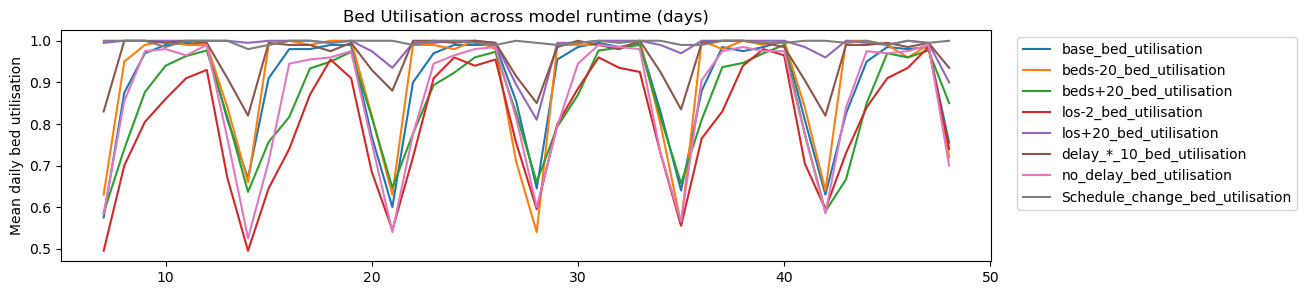

In [28]:
def scenario_daily_audit(scenario_results):
    """
    Daily audit results for each performance measure by scenario
    """
    columns = []
    daily_summary = pd.DataFrame()
    
    for sc_name, replications in scenario_results.items():
        daily_summary = pd.concat([daily_summary, replications.groupby(['sim_time']).mean()],
                                    axis=1)
        columns.append(sc_name)
    
    values = daily_summary['bed_utilisation']
    columns = list(map('_'.join, zip(columns, values)))
    values.columns = columns
    
    fig, ax = plt.subplots(figsize=(12,3))
    ax.plot(values)
    ax.set_title('Bed Utilisation across model runtime (days)')
    ax.set_ylabel('Mean daily bed utilisation')
    ax.legend(columns, bbox_to_anchor=(1.02, 1),loc='upper left')
    
    return (daily_summary, fig)
    
scenario_daily_audit(scenario_results[1]);
#plt.savefig('Daily bed utilisation scenarios')

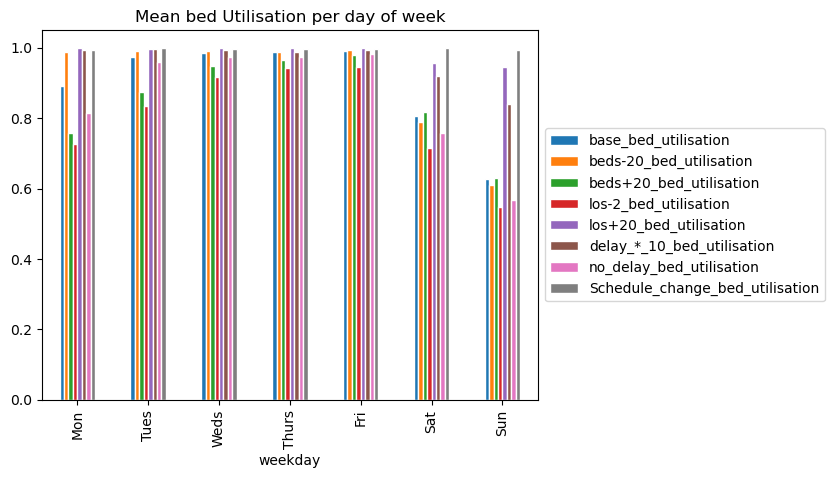

In [29]:
def scenario_weekly_audit(scenario_results):
    """
    Weekly audit results for each performance measure by scenario
    """
    columns = []
    weekly_summary = pd.DataFrame()
    
    for sc_name, replications in scenario_results.items():
        weekly_summary = pd.concat([weekly_summary, replications.groupby(['weekday']).mean()],
                                    axis=1)
        columns.append(sc_name)
        
    values = weekly_summary['bed_utilisation']
    columns = list(map('_'.join, zip(columns, values)))
    values.columns = columns
    day_map = {0: 'Mon', 1: 'Tues', 2: 'Weds', 3: 'Thurs', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
    values = values.rename(index=day_map)
    values.plot(kind='bar', stacked=False,edgecolor='white',
                title='Mean bed Utilisation per day of week')
    plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
    return (plt)    

plot1 = scenario_weekly_audit(scenario_results[1])
#plt.savefig('Mean daily bed utilisation scenarios')

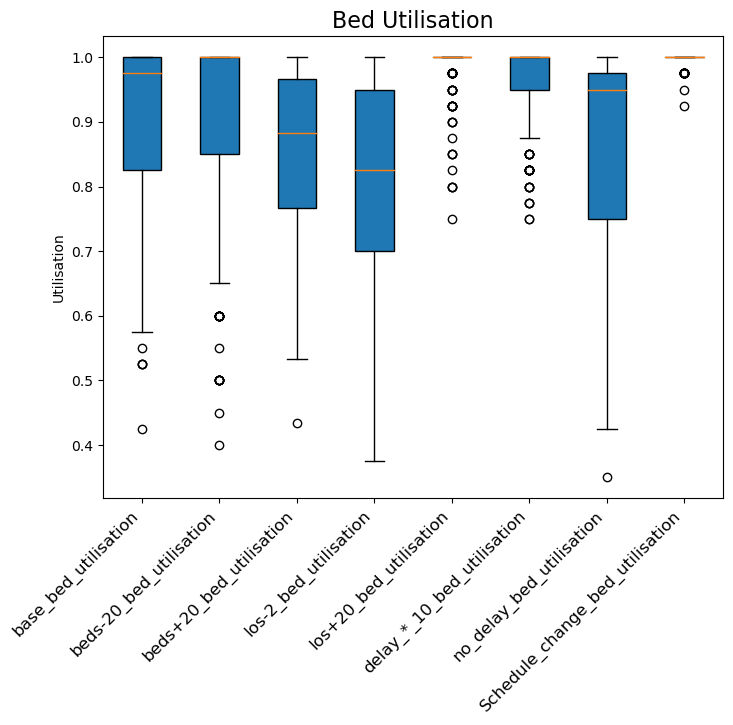

In [30]:
def scenario_weekly_boxplots(scenario_results):
    """
    Weekly audit results for each performance measure by scenario
    """
    columns = []
    weekly_summary = pd.DataFrame()

    for sc_name, replications in scenario_results.items():
            weekly_summary = pd.concat([weekly_summary, replications.groupby(['weekday']).apply(lambda x:x)],
                                axis=1)
            columns.append(sc_name)


    values = weekly_summary['bed_utilisation']
    columns = list(map('_'.join, zip(columns, values)))
    values.columns = columns
    
    fig, ax = plt.subplots(figsize=(8, 6))

    # create the boxplot
    bp = ax.boxplot(values.values, patch_artist=True)
    ax.set_ylabel('Utilisation')

    plt.xticks(range(1, len(values.columns) +1), values.columns)
    ax.set_xticklabels(values.columns, fontsize=12, rotation=45, ha='right')
    ax.set_title('Bed Utilisation', fontsize=16)

plot1 = scenario_weekly_boxplots(scenario_results[1])


In [31]:
def patient_scenarios(scenario_results):
    """
    Takes patient level results for each performance measure by scenario
    Selects lost slots to return lost slots 
    """
    columns = []
    patient_summary = pd.DataFrame()

    for sc_name, replications in scenario_results.items():

        patient_summary = pd.concat([patient_summary, replications.groupby(['Day', 'weekday'])\
                                     ['lost slots'].sum().astype(int)],axis=1) 
        columns.append(sc_name) 
        
    patient_summary = patient_summary.apply(lambda x: x / DEFAULT_NUMBER_OF_RUNS)
    columns = list(map('_'.join, zip(columns, patient_summary)))
    patient_summary.columns = columns
    patient_summary = patient_summary.reset_index()
    patient_summary.rename(columns = {'level_0':'Day', 'level_1':'weekday'}, inplace = True)
    
    return(patient_summary)

patient_summary = patient_scenarios(scenario_results_patients)


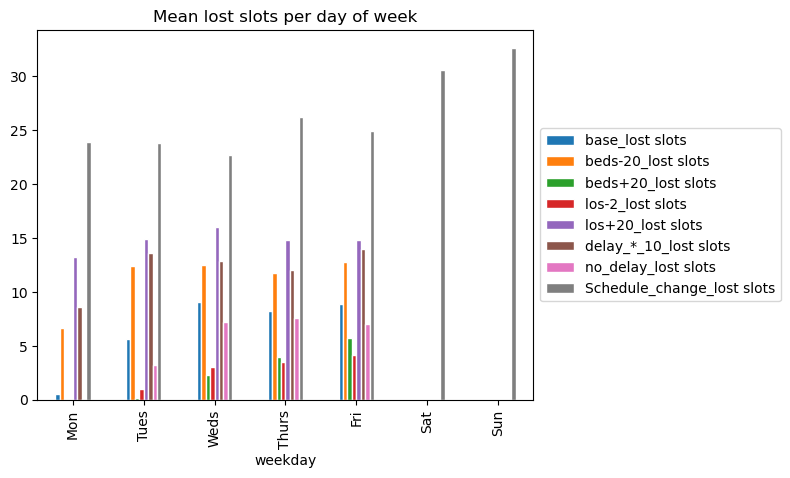

In [32]:
def lost_slots(patient_summary):

    """
    Takes output of previous function
    Deals with 0-day arrivals
    plot lost slots per scenario per weekday
    
    """
    patient_summ = (patient_summary.set_index('Day')
        .reindex(range(patient_summary.Day.iat[0],patient_summary.Day.iat[-1]+1), fill_value=0)
        .reset_index())
    shortseq = np.arange(len(range(0,7)))
    length = math.ceil(len(patient_summ) / 7)
        #create total sequence and flatten array list into list of elements
    sequence = ([np.tile((shortseq),length)])
    flat_seq = list(itertools.chain(*sequence))
        #truncate to correct length and save to column
    sequence = flat_seq[:len(patient_summ)]
    patient_summ['weekday'] = sequence 
    patient_summ = patient_summ.fillna(0)
    
    patient_summ = patient_summ[patient_summ["Day"] > DEFAULT_WARM_UP_PERIOD]    
    patient_summ = patient_summ.groupby('weekday').mean().reset_index()
    patient_summ = patient_summ.loc[:, patient_summ.columns != 'Day']
    day_map = {0: 'Mon', 1: 'Tues', 2: 'Weds', 3: 'Thurs', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
    patient_summ['weekday'] = patient_summ['weekday'].map(day_map)
    patient_summ.plot(kind='bar', stacked=False, edgecolor='white', 
                      x='weekday', title='Mean lost slots per day of week')
    plt.legend(loc='center left', bbox_to_anchor=(1,0.5))

    return(plt)

plot2 = lost_slots(patient_summary)
#plt.savefig('Mean daily lost slots scenarios')

,base_Counts,beds-20_Counts,beds+20_Counts,los-2_Counts,los+20_Counts,delay_*_10_Counts,no_delay_Counts,Schedule_change_Counts,run time (days)
0,276.2,134.2,388.6,391.0,53.2,114.0,309.0,314.6,42


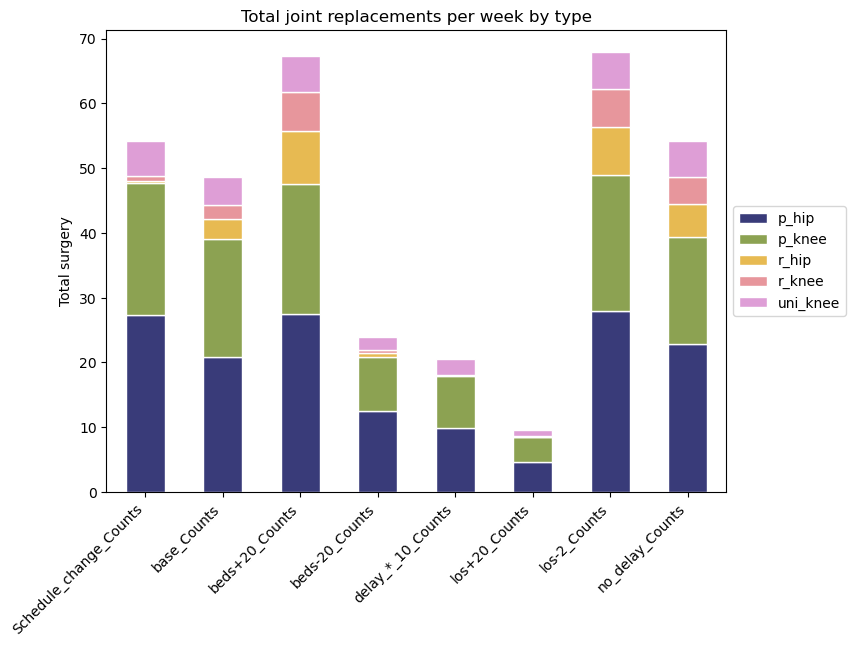

In [33]:
def total_thruput_pt_results(scenario_results): 
    
    """
    Takes patient level results for each performance measure by scenario
    Deal with 0-day arrivals
    Return plot of total thruput stacked by surgery type per scenario
    
    """
    
    columns = []
    patient_summary = pd.DataFrame()

    for sc_name, replications in scenario_results.items():
        
        replications = replications[replications['lost slots'] == False]
        replications = replications[replications['Day'] > DEFAULT_WARM_UP_PERIOD]
        replications = replications[['Day','weekday','surgery type', 'depart']]
        
        patient_summary = pd.concat([patient_summary, replications.groupby(['Day','weekday','surgery type'])\
                                     ['surgery type'].count()],axis=1)

        columns.append(sc_name)  

    patient_summary.rename(columns = {'surgery type':'Counts'}, inplace = True)
    patient_summary = patient_summary.assign(Counts = lambda x: (x['Counts'] / DEFAULT_NUMBER_OF_RUNS)).fillna(0)
    columns = list(map('_'.join, zip(columns, patient_summary)))
    patient_summary.columns = columns
    patient_summary = patient_summary.reset_index()
    patient_summary.rename(columns = {'level_0':'Day', 'level_1':'weekday', 'level_2':'surgery type'}, inplace = True)
    patient_summary = pd.DataFrame(patient_summary.groupby(['weekday','surgery type'])[columns].mean())
    
    patient_summary = patient_summary.reset_index()
    day_map = {0: 'Mon', 1: 'Tues', 2: 'Weds', 3: 'Thurs', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
    
    values=patient_summary.filter(regex='_Counts')
    melted_df = pd.melt(patient_summary, id_vars=['weekday', 'surgery type'], value_vars=list(values), 
                        var_name='_Counts', value_name='Counts')

    # plot the stacked bar chart
    fig, ax = plt.subplots(figsize=(8, 6))
    melted_df.groupby(['_Counts', 'surgery type']).sum()['Counts'].unstack().plot(kind='bar', 
                                    stacked=True, ax=ax, colormap='tab20b', edgecolor='white')
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    plt.ylabel('Total surgery')
    plt.xlabel('')
    plt.title('Total joint replacements per week by type')
    plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
    
    return plt

def total_thruput_table(scenario_results):
    
    """
    Takes patient level results for each performance measure by scenario
    Removes lost slots (never had surgery)
    Returns table of total throuput across run-time
    (Add run time value)
    """
    
    columns = []
    patient_summary = pd.DataFrame()

    for sc_name, replications in scenario_results.items():
        
        replications = replications[replications['lost slots'] == False]
        replications = replications[replications['Day'] > DEFAULT_WARM_UP_PERIOD]
        replications = replications[['Day','weekday', 'lost slots']]
        
        patient_summary = pd.concat([patient_summary, replications.groupby(['Day','weekday'])\
                                     ['lost slots'].count()],axis=1) 

        columns.append(sc_name)
        
    patient_summary.rename(columns = {'lost slots':'Counts'}, inplace = True)
    patient_summary = patient_summary.assign(Counts = lambda x: (x['Counts'] / DEFAULT_NUMBER_OF_RUNS)).fillna(0)
    columns = list(map('_'.join, zip(columns, patient_summary)))
    patient_summary.columns = columns
    patient_summary = patient_summary.reset_index()
    patient_summary = patient_summary.drop(['level_0', 'level_1'], axis=1)
    values=patient_summary.filter(regex='_Counts')
    patient_summary = pd.DataFrame(patient_summary.sum(axis=0)).T
    patient_summary['run time (days)'] = DEFAULT_RESULTS_COLLECTION_PERIOD

    return patient_summary

    ######################################

thruput = total_thruput_pt_results(scenario_results_patients)
table = total_thruput_table(scenario_results_patients)
table